<a href="https://colab.research.google.com/github/ngyope/Propensity_Score_Methods/blob/master/Propensity_Score_Methods_Lalonde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
library(tidyverse)
library(haven)
install.packages("MatchIt"); library(MatchIt)
install.packages("WeightIt"); library(WeightIt)
install.packages("cobalt");library(cobalt)
install.packages("gbm"); library(gbm)
install.packages("CBPS"); library(CBPS)
install.packages("causalsens"); library(causalsens)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



This scripts uses the famous Lalonde data. So, let's get it.

In [0]:
cps1_data <- read_dta("https://users.nber.org/~rdehejia/data/cps_controls.dta")
cps3_data <- read_dta("https://users.nber.org/~rdehejia/data/cps_controls3.dta")
nswdw_data <- read_dta("https://users.nber.org/~rdehejia/data/nsw_dw.dta")

In [0]:
# Extract the treatment group from NSW Data and treat it as a treatment group in CPS1.
cps1_nsw_data <- nswdw_data %>% filter(treat==1) %>% rbind(cps1_data)

# Extract the treatment group from NSW Data and treat it as a treatment group in CPS3.
cps3_nsw_data <- nswdw_data %>% filter(treat==1) %>% rbind(cps3_data)

Define the formulas previously.

In [0]:
# Formula of outcome model
frml_out <- as.formula(re78 ~ treat + age + education + black + hispanic + married + nodegree + re74 + re75 + I(re74^2) + I(re75^2))

# Formula of treatment model
frml_treat <- as.formula(treat ~ age + education + black + hispanic + married + nodegree + re74 + re75 + I(re74^2) + I(re75^2))

Create matching models.

In [0]:
# nearest neighbors
m_out_nn_1 <- matchit(frml_treat, cps1_nsw_data, method="nearest", ratio=1, replace=TRUE, discard="both")
m_out_nn_4 <- matchit(frml_treat, cps1_nsw_data, method="nearest", ratio=4, replace=TRUE, discard="both")

# subclassification
m_out_subclass <- matchit(frml_treat, cps1_nsw_data, method="subclass", subclass=10, discard="both")

# caliper matching
m_out_caliper <- matchit(frml_treat, cps1_nsw_data, method="nearest", replace=TRUE, caliper=.01, ratio=1, discard="both")

Create Weighting models.

In [26]:
# models
w_out_ps <- weightit(frml_treat, cps1_nsw_data, method="ps", estimand="ATT")
w_out_gbm <- weightit(frml_treat, cps1_nsw_data, method="gbm", stop.method="es.mean", estimand="ATT", bag.fraction=0.7, cv.folds=5)
w_out_cbps <- weightit(frml_treat, cps1_nsw_data, method="cbps", estimand="ATT")

Warning message:
“Some extreme weights were generated. Examine them with summary() and maybe trim them with trim().”
Warning message:
“Some extreme weights were generated. Examine them with summary() and maybe trim them with trim().”
Warning message:
“Some extreme weights were generated. Examine them with summary() and maybe trim them with trim().”


In [28]:
print(summary(w_out_ps))
print(summary(w_out_gbm))
print(summary(w_out_cbps))

                 Summary of weights

- Weight ranges:

        Min                                   Max
treated   1                             || 1.0000
control   0  |---------------------------| 1.0535

- Units with 5 greatest weights by group:
                                         
             1     2      4      6      7
 treated     1     1      1      1      1
          7778 15758   2782   7777   2769
 control 1.044 1.044 1.0487 1.0487 1.0535

- Weight statistics:

        Coef of Var   MAD   Entropy
treated       0.000 0.000      0.00
control       6.419 1.662 -23621.18
overall       5.618 1.756 -11934.31

- Effective Sample Sizes:

             Control Treated
Unweighted 15992.000     185
Weighted     378.932     185
                 Summary of weights

- Weight ranges:

        Min                                  Max
treated   1   ||                           1.000
control   0 |---------------------------| 15.593

- Units with 5 greatest weights by group:
               

In [29]:
# Trimming and re-check the summary.
w_out_ps_trm <- w_out_ps %>% trim(at=5, lower=TRUE)
w_out_gbm_trm <- w_out_gbm %>% trim(at=2, lower=TRUE)
w_out_cbps_trm <- w_out_cbps %>% trim(at=5, lower=TRUE)
summary(w_out_ps_trm)
summary(w_out_gbm_trm)
summary(w_out_cbps_trm)

Trimming the top and bottom 5 weights where treat ≠ 1.

Trimming the top and bottom 2 weights where treat ≠ 1.

Trimming the top and bottom 5 weights where treat ≠ 1.



                 Summary of weights

- Weight ranges:

        Min                                   Max
treated   1                             || 1.0000
control   0  |---------------------------| 1.0384

- Units with 5 greatest weights by group:
                                           
              1      2      4      6      7
 treated      1      1      1      1      1
           2769   2782   7777   7778  11531
 control 1.0384 1.0384 1.0384 1.0384 1.0384

- Weight statistics:

        Coef of Var   MAD   Entropy
treated       0.000 0.000      0.00
control       6.417 1.662 -23631.41
overall       5.618 1.756 -11937.96

- Effective Sample Sizes:

             Control Treated
Unweighted 15992.000     185
Weighted     379.151     185

                 Summary of weights

- Weight ranges:

        Min                                  Max
treated   1      ||                       1.0000
control   0 |---------------------------| 6.0446

- Units with 5 greatest weights by group:
                                         
             1     2      4      5      6
 treated     1     1      1      1      1
         11263 14606   2770   5492   6880
 control 3.226 3.226 6.0446 6.0446 6.0446

- Weight statistics:

        Coef of Var   MAD    Entropy
treated       0.000 0.000      0.000
control      13.946 1.697 -16698.353
overall       7.900 1.803  -6848.121

- Effective Sample Sizes:

             Control Treated
Unweighted 15992.000     185
Weighted      81.814     185

                 Summary of weights

- Weight ranges:

        Min                                   Max
treated   1                             || 1.0000
control   0  |---------------------------| 1.0509

- Units with 5 greatest weights by group:
                                           
              1      2      3      4      5
 treated      1      1      1      1      1
           2769   2782   3546   5492   5818
 control 1.0509 1.0509 1.0509 1.0509 1.0509

- Weight statistics:

        Coef of Var   MAD   Entropy
treated       0.000 0.000      0.00
control       6.407 1.661 -23561.99
overall       5.612 1.757 -11915.45

- Effective Sample Sizes:

             Control Treated
Unweighted 15992.000     185
Weighted     380.378     185

Check the covariate balance by love.plot() in "cobalt" package.

Warning message:
“Removed 1 rows containing missing values (geom_vline).”


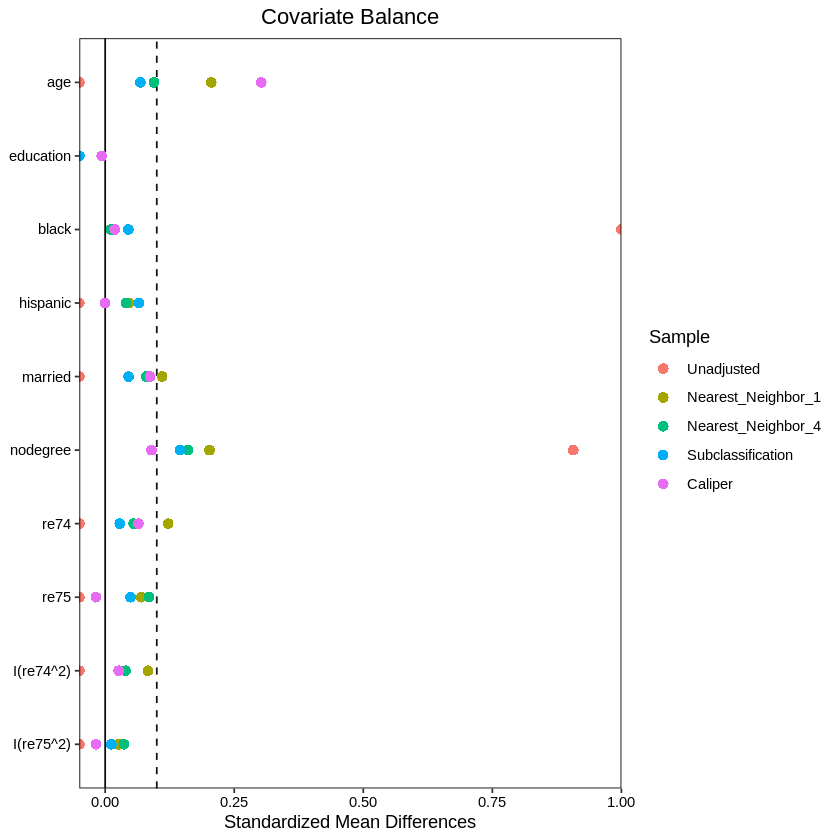

In [30]:
# matching models
love.plot(frml_treat, data=cps1_nsw_data,
          weights=data.frame(Nearest_Neighbor_1=get.w(m_out_nn_1),
                             Nearest_Neighbor_4=get.w(m_out_nn_4),
                             Subclassification=get.w(m_out_subclass),
                             Caliper=get.w(m_out_caliper)),
          method=c("matching", "matching", "matching", "matching"),
          binary="std", s.d.denom="treated", grid=FALSE, threshold=.1, limits=c(0,1))

Warning message:
“Removed 1 rows containing missing values (geom_vline).”


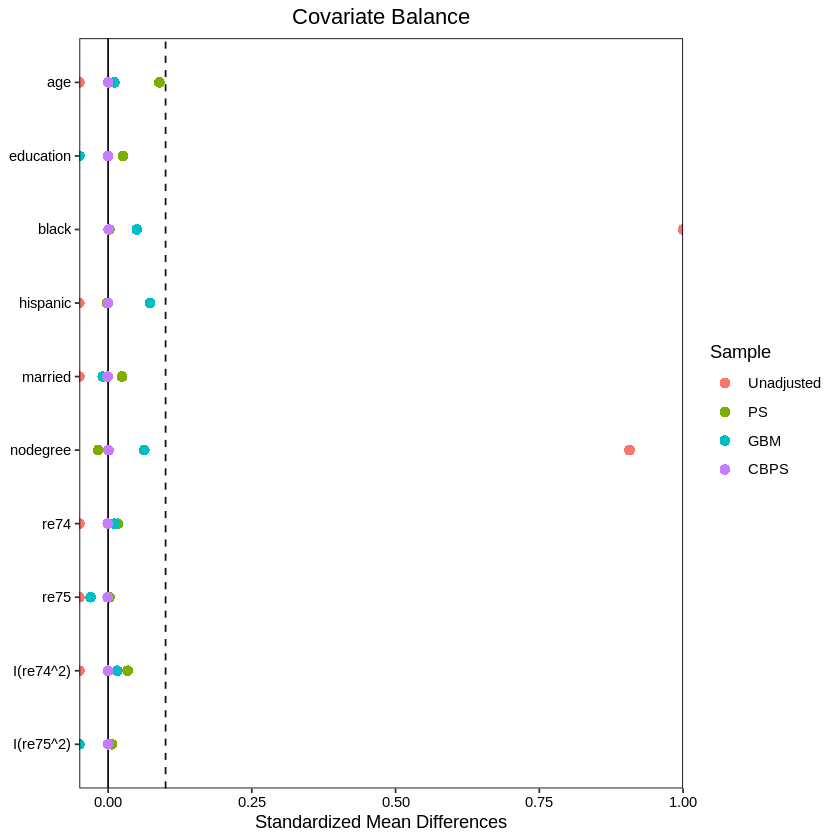

In [31]:
# Weighting models
love.plot(frml_treat, data=cps1_nsw_data,
          weights=data.frame(PS=get.w(w_out_ps_trm),
                             GBM=get.w(w_out_gbm_trm),
                             CBPS=get.w(w_out_cbps_trm)),
          method=c("weighting", "weighting", "weighting"),
          binary="std", s.d.denom="treated", grid=FALSE, threshold=.1, limits=c(0,1))

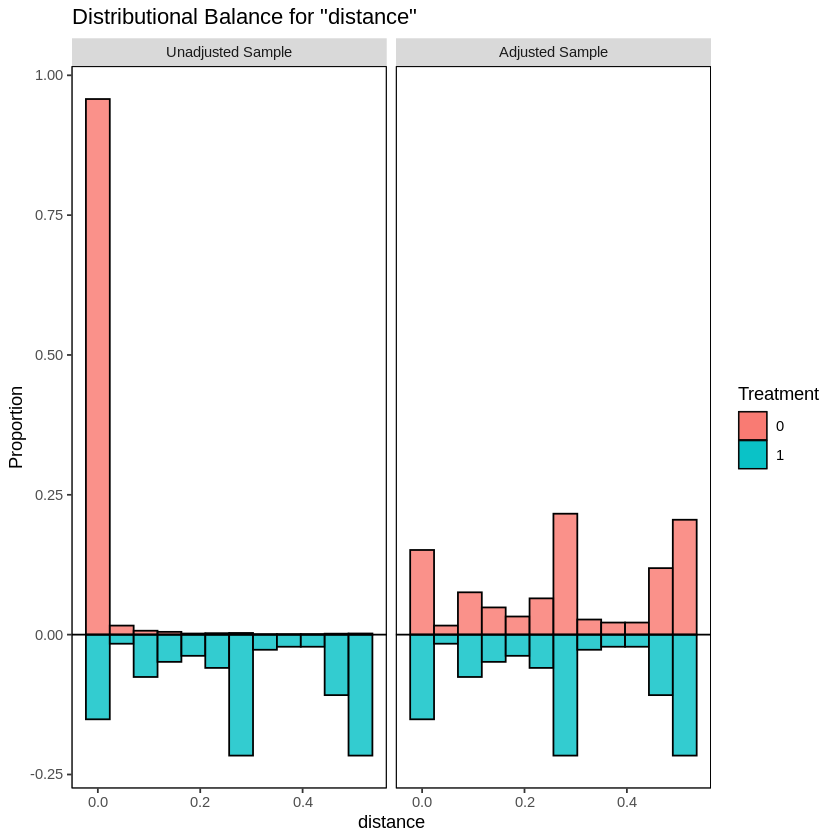

In [18]:
# check the covariate balance per covariate
bal.plot(m_out_nn_1, var.name="distance", which="both", type="histogram", mirror=TRUE)

Get the estimated ATT via the linear model.

In [32]:
# matching methods
matched_data <- list(match.data(m_out_nn_1),
                     match.data(m_out_nn_4),
                     match.data(m_out_subclass),
                     match.data(m_out_caliper))
model_label1 <- c("nearest neighbor ratio 1", "nearest neighbor ratio 4", "subclassification", "caliper")

for(i in 1:length(matched_data)){
  print(model_label1[[i]])
  print(lm(re78 ~ treat, data=matched_data[[i]]) %>% broom::tidy())
}

[1] "nearest neighbor ratio 1"
# A tibble: 2 x 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)    5140.      626.      8.21 5.71e-15
2 treat          1209.      819.      1.48 1.41e- 1
[1] "nearest neighbor ratio 4"
# A tibble: 2 x 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)    5684.      366.     15.5  2.38e-45
2 treat           665.      636.      1.05 2.96e- 1
[1] "subclassification"
# A tibble: 2 x 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)    8597.      105.     81.5  0       
2 treat         -2248.      623.     -3.61 0.000313
[1] "caliper"
# A tibble: 2 x 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)    4958.      606.      8.18 1.17e-14
2 treat          1374.      815.      1.69 9.30e

In [33]:
# weighting methods
weighted_data <- list(w_out_ps_trm, w_out_gbm_trm, w_out_cbps_trm)
model_label2 <- c("PS", "GBM", "CBPS")

for(i in 1:length(weighted_data)){
  print(model_label2[[i]])
  print(lm(re78 ~ treat, data=cps1_nsw_data, weights=weighted_data[[i]]$weights) %>% broom::tidy())
}

[1] "PS"
# A tibble: 2 x 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)    5104.      78.8      64.8 0.      
2 treat          1246.     111.       11.2 6.31e-29
[1] "GBM"
# A tibble: 2 x 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)    5001.      90.0      55.5 0.      
2 treat          1349.     117.       11.5 1.00e-30
[1] "CBPS"
# A tibble: 2 x 5
  term        estimate std.error statistic  p.value
  <chr>          <dbl>     <dbl>     <dbl>    <dbl>
1 (Intercept)    5085.      79.1      64.3 0.      
2 treat          1264.     112.       11.3 1.76e-29


Doubly Robust Estimator.

In [64]:
# weighting methods
weighted_data <- list(w_out_ps_trm, w_out_gbm_trm, w_out_cbps_trm)
model_label2 <- c("PS", "GBM", "CBPS")

for(i in 1:length(weighted_data)){
  print(model_label2[[i]])
  print(lm(frml_out, data=cps1_nsw_data, weights=weighted_data[[i]]$weights) %>% broom::tidy())
}

[1] "PS"
# A tibble: 12 x 5
   term             estimate    std.error statistic   p.value
   <chr>               <dbl>        <dbl>     <dbl>     <dbl>
 1 (Intercept)  2869.        515.             5.58  2.49e-  8
 2 treat        1167.        105.            11.1   1.11e- 28
 3 age           -24.5         6.39          -3.84  1.24e-  4
 4 education     369.         31.7           11.7   2.75e- 31
 5 black       -1485.        178.            -8.32  9.43e- 17
 6 hispanic      -75.9       275.            -0.276 7.83e-  1
 7 married      -168.        151.            -1.11  2.67e-  1
 8 nodegree     -318.        166.            -1.91  5.60e-  2
 9 re74           -0.541       0.0306       -17.7   3.55e- 69
10 re75            0.737       0.0415        17.8   6.54e- 70
11 I(re74^2)       0.0000315   0.00000124    25.4   5.36e-140
12 I(re75^2)      -0.0000193   0.00000214    -9.03  1.99e- 19
[1] "GBM"
# A tibble: 12 x 5
   term            estimate    std.error statistic   p.value
   <chr>      

Sensitivity analysis.

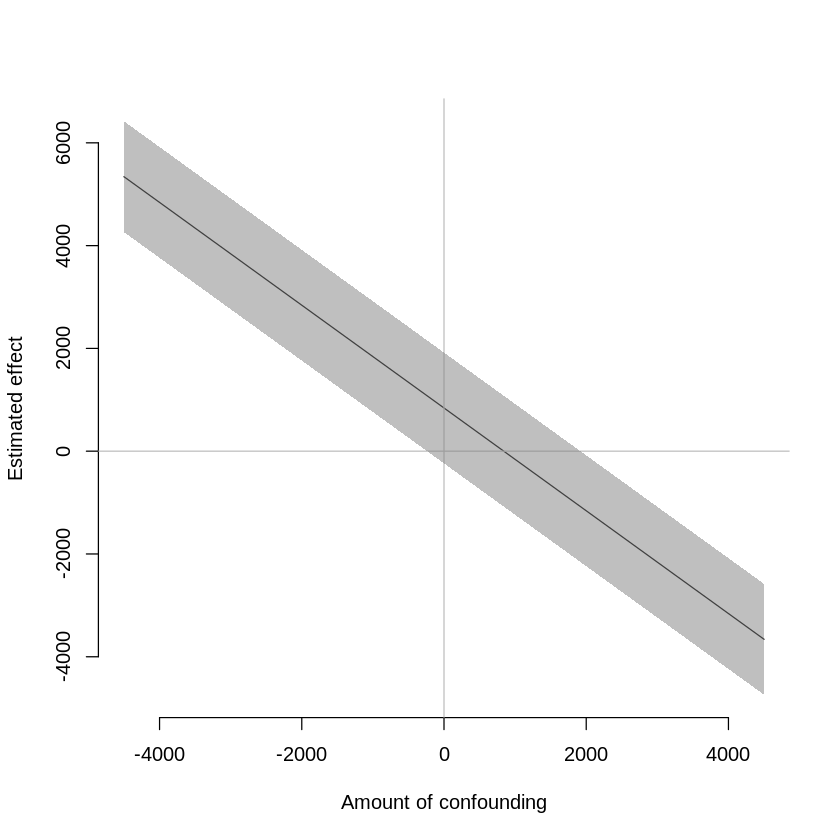

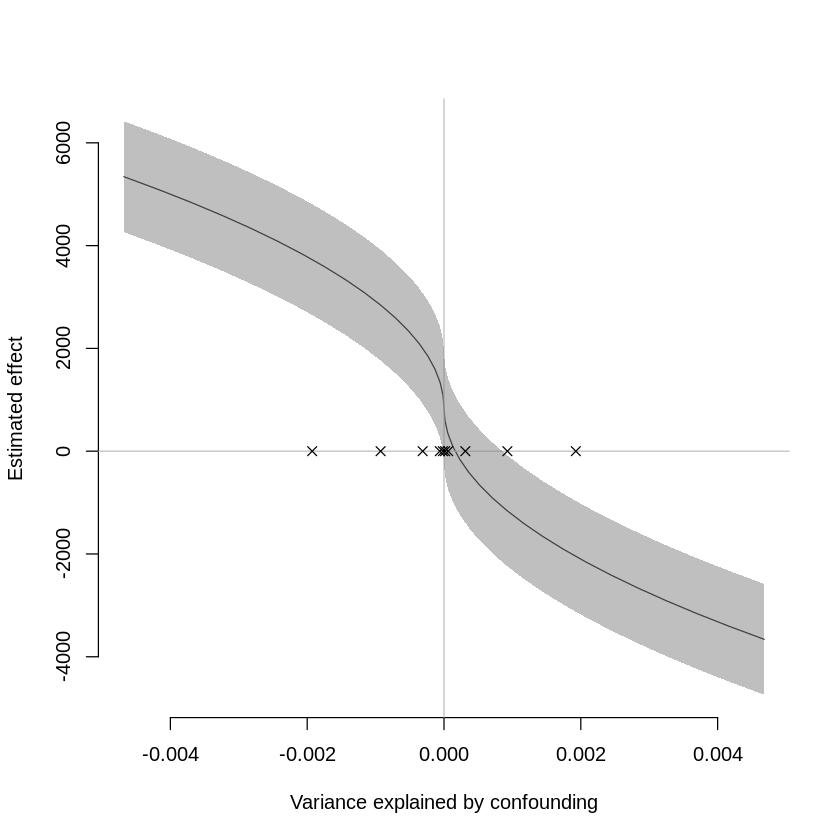

In [104]:
model_out <- lm(frml_out, data=cps1_nsw_data)
model_treat <- glm(frml_treat, data=cps1_nsw_data, family=binomial())
alpha <- seq(-4500, 4500, by = 250)

ll_sens <- causalsens(model_out, model_treat, ~ age + education, data=cps1_nsw_data, confound=one.sided.att, alpha=alpha)

plot(ll_sens, type="raw", bty="n")
plot(ll_sens, type="r.squared", bty="n")